# Lab 2.5 Unfolding the Mysteries of TUnfold

In [14]:
import ROOT
from ROOT import TFile, TTree, TObject, TH2D, TH1D, TH1, TH2
from ROOT import TRandom3, TMath
from ROOT import TGraph, TSpline, TCanvas
from ROOT import TUnfold, TUnfoldDensity
from ROOT import kTRUE
from ROOT import kRed
from array import array

TH1.SetDefaultSumw2() # Turn on histogram errors
ROOT.gStyle.SetOptFit(1111) # Show fit results
rnd = TRandom3() # rng
gHistInvEMatrix = ROOT.MakeNullPointer(ROOT.TH2)
# gFitter = ROOT.TVirtualFitter() <- Don't need unless we use custom fitter...

In [2]:
# data and MC luminosity, cross-section
n_reco = 100
n_gen = 40
xmin_reco = 0.0
xmax_reco = 800.0
xmin_gen = 0.0
xmax_gen = 800.0

#Import ROOT File and TTree
root_file = TFile.Open("../../Datasets/TTbar/ee_ttbarsignalplustau.root")
tree = root_file.Get("ttBar_treeVariables_step8")

In [3]:
# Create and fill MC and migration matrix
h_lpt_gen_MC = TH1D("MCLptGen", ";pt_{l Gen}", n_gen, xmin_gen, xmax_gen)
h_lpt_reco_MC = TH1D("MCLptReco", ";pt_{l Reco}", n_reco, xmin_reco, xmax_reco)
# This is our migration matrix
h_lpt_gen_reco_MC = TH2D("MCLptGenReco", ";pt_{reco};pt_{gen}", n_reco, xmin_reco, xmax_reco,
                            n_gen, xmin_gen, xmax_gen)

entries = tree.GetEntries()
for i in range(entries):
    tree.GetEntry(i)
    h_lpt_gen_MC.Fill(tree.gen_l_pt)
    h_lpt_reco_MC.Fill(tree.l_pt)
    # Prevent overflow and underflow bins from being filled
    if tree.l_pt < xmin_reco or tree.l_pt > xmax_reco or tree.gen_l_pt < xmin_gen or tree.gen_l_pt > xmax_gen:
        continue
    h_lpt_gen_reco_MC.Fill(tree.l_pt, tree.gen_l_pt) # <- migration matrix

In [4]:
# TODO: Generate an alternative MC for comparison of systematic uncertainties
h_lpt_genreco_sys_MC = TH2D("LptGenRecoSysMC", ";pt_{reco};pt_{gen}", n_reco, xmin_reco, xmax_reco,
                            n_gen, xmin_gen, xmax_gen)

In [5]:
# TODO: Obtain data distribution... may not be necessary
# We will never have data at the generated level since we only see reconstructed data...
h_lpt_gen_data = TH1D("DataLptGen", ";pt_{l Gen}", n_gen, xmin_gen, xmax_gen) # <- impossible to get
h_lpt_reco_data = TH1D("DataLptReco", ";pt_{l Reco}", n_reco, xmin_reco, xmax_reco)
h_lpt_gen_reco_data = TH2D("DataLptGenReco", ";pt_{reco};pt_{gen}", n_reco, xmin_reco, xmax_reco,
                            n_gen, xmin_gen, xmax_gen)

# For now use MC data as actual data....
for i in range(entries):
    tree.GetEntry(i)
    h_lpt_reco_data.Fill(tree.l_pt)

In [6]:
# Divide by bin width to get density distributions
h_density_gen_MC = TH1D("DensityGenMC", ";pt_{l Gen}", n_gen, xmin_gen, xmax_gen)
h_density_gen_data = TH1D("DensityGenData", ";pt_{l Gen}", n_gen, xmin_gen, xmax_gen)

for i in range(n_gen):
    # TODO: Set bin content for density plot for data 
    h_density_gen_MC.SetBinContent(i, h_lpt_gen_MC.GetBinContent(i) / h_lpt_gen_MC.GetBinWidth(i))

In [7]:
# Start the unfolding...
unfold = TUnfoldDensity(h_lpt_gen_reco_MC, TUnfold.kHistMapOutputVert)

if unfold.SetInput(h_lpt_reco_data) >= 10000:
    print "WARNING!!! Unfolding result may be wrong..."

Info in <TUnfold::SetConstraint>: fConstraint=1
Warning in <TUnfold::TUnfold>: 14 output bins do not depend on the input data  0 26 29-30 32-41
Info in <TUnfold::TUnfold>: 100 input bins and 28 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (yaxis:pt_{gen}[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #26 (yaxis:pt_{gen}[500,520])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #29 (yaxis:pt_{gen}[560,580])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #30 (yaxis:pt_{gen}[580,600])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #32 (yaxis:pt_{gen}[620,640])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #33 (yaxis:pt_{gen}[640,660])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #34 (yaxis:pt_{gen}[660,680])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #35 (yaxis:pt_{gen}[680,700])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #36 (yaxis:pt_{gen}[700,720])
Info in <TUnfoldDensity::TUnfold>:

In [8]:
# Unfolding is done here.
n_scan = 30
tau_min = 0.0
tau_max = 0.0
ls_Curve = TGraph()

log_tau_x = ROOT.MakeNullPointer(ROOT.TSpline)
log_tau_y = ROOT.MakeNullPointer(ROOT.TSpline)
iBest = unfold.ScanLcurve(n_scan, tau_min, tau_max, ls_Curve, log_tau_x, log_tau_y)

Info in <TUnfoldDensity::ScanLcurve>: logtau=-Infinity X=-26.024795 Y=6.165277
Info in <TUnfoldDensity::ScanLcurve>: logtau=-2.458061 X=-1.532033 Y=6.163835
Info in <TUnfoldDensity::ScanLcurve>: logtau=-2.958061 X=-3.529388 Y=6.165133
Info in <TUnfoldDensity::ScanLcurve>: logtau=-3.458061 X=-5.529123 Y=6.165263
Info in <TUnfoldDensity::ScanLcurve>: logtau=-3.958061 X=-7.529096 Y=6.165276
Info in <TUnfoldDensity::ScanLcurve>: logtau=-4.458061 X=-9.529094 Y=6.165277
Info in <TUnfoldDensity::ScanLcurve>: logtau=-4.958061 X=-11.529093 Y=6.165277
Info in <TUnfoldDensity::ScanLcurve>: logtau=-5.458061 X=-13.529093 Y=6.165277
Info in <TUnfoldDensity::ScanLcurve>: logtau=-5.958061 X=-15.529092 Y=6.165277
Info in <TUnfoldDensity::ScanLcurve>: logtau=-6.458061 X=-17.529114 Y=6.165277
Info in <TUnfoldDensity::ScanLcurve>: logtau=-6.958061 X=-19.529517 Y=6.165277
Info in <TUnfoldDensity::ScanLcurve>: logtau=-7.458061 X=-21.529778 Y=6.165277
Info in <TUnfoldDensity::ScanLcurve>: logtau=-7.958061 X=

In [9]:
# TODO: Define a correlated systematic error and add to the unfolding

print "The regularization constant being used is: tau = " + str(unfold.GetTau())
print "The chi-squared value for this unfolding is: " + str(unfold.GetChi2A()) + " + " + str(unfold.GetChi2L()) + " / " + str(unfold.GetNdf())

t = array('d', [0, 0])
x = array('d', [0, 0])
y = array('d', [0, 0])
log_tau_x.GetKnot(iBest, ROOT.Double(t[0]), ROOT.Double(x[0]))
log_tau_y.GetKnot(iBest, ROOT.Double(t[0]), ROOT.Double(y[0]))

best_L_curve = TGraph(1, x, y)
best_log_tau_log_chi2 = TGraph(1, t, x)
    
# Retrieve results into histograms

# Get unfolded distribution
h_lpt_unfold = unfold.GetOutput("Unfolded")

# Get unfolding result, folded back
h_lpt_reco_fold = unfold.GetFoldedOutput("FoldedBack")

# Get error matrix (input distribution statistical errors only)
# h_err_matrix_data = unfold.GetEmatrix("EmatData")

# Get total error matrix:
#   migration matrix uncorrelated and correlated systematic errors
#   added in quadrature to the data statistical errors
h_err_matrix_total = unfold.GetEmatrixTotal("EmatTotal")

# Create data histogram with the total errors
h_total_error = TH1D("TotalError", ";pt_{l Gen}", n_gen, xmin_gen, xmax_gen)

for _bin in range(n_gen):
    h_total_error.SetBinContent(_bin, h_lpt_unfold.GetBinContent(_bin))
    h_total_error.SetBinError(_bin, TMath.Sqrt(h_err_matrix_total.GetBinContent(_bin, _bin)))

The regularization constant being used is: tau = 0.000151139127139
The chi-squared value for this unfolding is: 1.04870349496e-07 + 0.0334216812878 / 34


In [10]:
# Get global correlation coefficients
# For this calculation one has to specify whethe the underflow/overflow bins are included or not
# default: include all bins
# here: exclude underflow and overflow bins

# 1st 0: use default title
# second 0: all distributions
# *[UO]: discard underflow and overflow bins on all axes
# kTrue: use original binning
# ghistInvEMatrix: used to store the inverse of the error matrix
h_rho_i = unfold.GetRhoItotal("rho_I",  '0',  '0', "*[U0]", kTRUE, gHistInvEMatrix)

# TODO: Fit unfolded data using the full error matrix. See the function
# chisquare_corr in the example....

SystemError: TH1* TUnfoldDensity::GetRhoItotal(const char* histogramName, const char* histogramTitle = 0, const char* distributionName = 0, const char* projectionMode = 0, bool useAxisBinning = kTRUE, TH2** ematInv = 0) =>
    problem in C++; program state has been reset


 *** Break *** segmentation violation



There was a crash.
This is the entire stack trace of all threads:

Thread 10 (Thread 0x7fd7f555e700 (LWP 12743)):
#0  0x00007fd829ecf6d6 in futex_abstimed_wait_cancelable (private=0, abstime=0x0, expected=0, futex_word=0x559054b59700) at ../sysdeps/unix/sysv/linux/futex-internal.h:205
#1  do_futex_wait (sem=sem
entry=0x559054b59700, abstime=0x0) at sem_waitcommon.c:111
#2  0x00007fd829ecf7c8 in __new_sem_wait_slow (sem=0x559054b59700, abstime=0x0) at sem_waitcommon.c:181
#3  0x0000559053032634 in PyEval_RestoreThread ()
#4  0x00005590530ef84d in ?? ()
#5  0x000055905304f4ca in PyEval_EvalFrameEx ()
#6  0x000055905304cd0a in PyEval_EvalCodeEx ()
#7  0x00005590530545fe in PyEval_EvalFrameEx ()
#8  0x000055905304cd0a in PyEval_EvalCodeEx ()
#9  0x00005590530688bc in ?? ()
#10 0x000055905303877e in PyObject_Call ()
#11 0x0000559053051a21 in PyEval_EvalFrameEx ()
#12 0x0000559053054232 in PyEval_EvalFrameEx ()
#13 0x0000559053054232 in PyEval_EvalFr

'\n  // show tau as a function of chi**2\n  output->cd(5);\n  logTauX->Draw();\n  bestLogTauLogChi2->SetMarkerColor(kRed);\n  bestLogTauLogChi2->Draw("*");\n  // show the L curve\n  output->cd(6);\n  lCurve->Draw("AL");\n  bestLcurve->SetMarkerColor(kRed);\n  bestLcurve->Draw("*");\n  output->SaveAs("testUnfold1.png");\n  output->Draw();\n  return 0'

Warning in <TCanvas::Constructor>: Deleting canvas with same name: output
Warning in <TFile::Append>: Replacing existing TH1: LptInput (Potential memory leak).


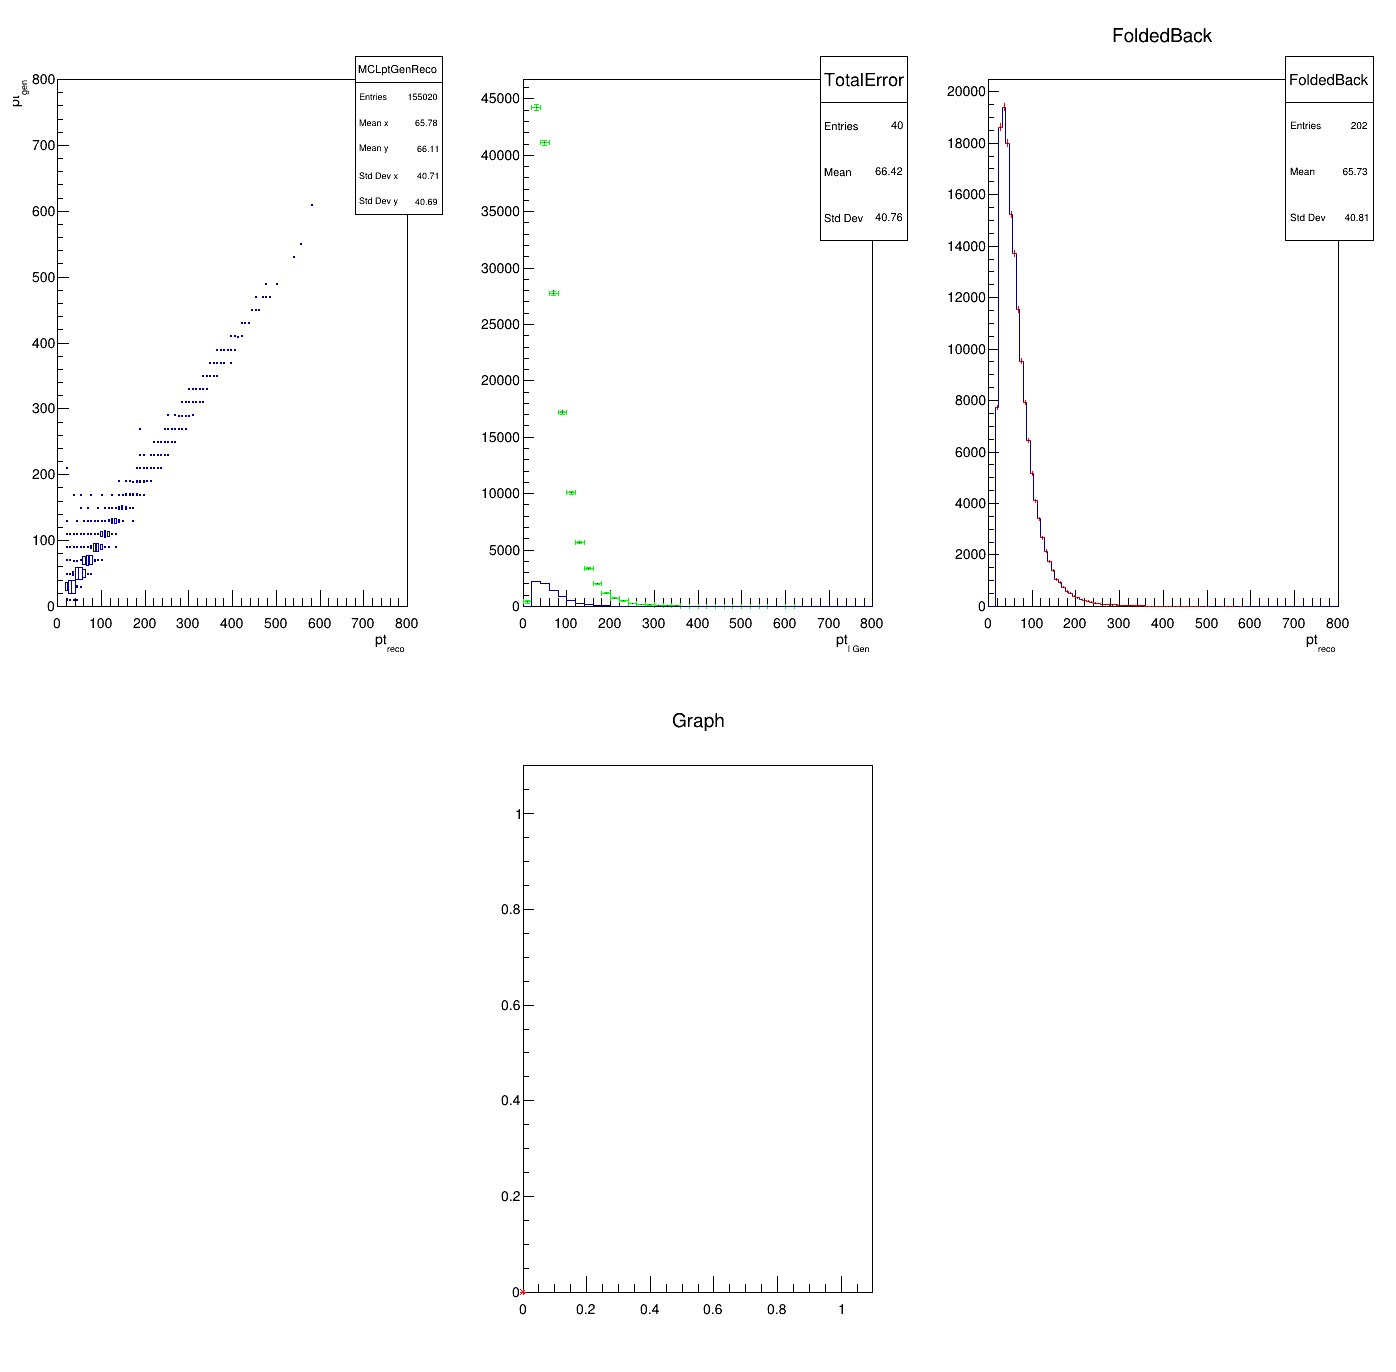

In [30]:
# Let's plot this!!!

output = TCanvas("output", "output", 1400, 1400)
output.Divide(3, 2)

# Show the matrix which connects the input and output
# Overflow bins not shown or used, but helps improve the result
# overflow bins at bottom contain the background shape
# overflow bins to the left and right contain events which are not reconstructed.
# Those are necessary for proper MC normalisation
output.cd(1)
h_lpt_gen_reco_MC.Draw("BOX")

# Draw generator-level distribution:
#   - MC input (black) [with completely wrong peak position and shape]
#   - unfolded data (blue)
output.cd(2)
h_total_error.SetLineColor(ROOT.kBlue)
h_total_error.Draw("E")

h_lpt_unfold.SetLineColor(ROOT.kGreen)
h_lpt_unfold.Draw("SAME E1")

h_density_gen_MC.Draw("SAME HIST")

# Draw detector level distributions
#   - data (red)
#   - MC (black) [with completely wrong peak position and shape]
#   - unfolded data (blue)
output.cd(3)
h_lpt_reco_fold.SetLineColor(ROOT.kBlue)
h_lpt_reco_fold.Draw()
h_lpt_reco_MC.Draw("SAME HIST")
h_input = unfold.GetInput("LptInput", ";pt_{l Reco}")
h_input.SetLineColor(kRed)
h_input.Draw("SAME")

# Show correlation coefficients
#output.cd(4)
#h_rho_i.Draw()

# Show tau as a function of chi-sqaured
output.cd(5)
log_tau_x.Draw()
best_log_tau_log_chi2.SetMarkerColor(ROOT.kRed)
best_log_tau_log_chi2.SetMarkerSize(0.7)
best_log_tau_log_chi2.Draw("*")

# Show the L curve
output.cd(6)
l_curve.Draw("AL")
best_l_curve.SetMarkerColor(ROOT.kRed)
best_l_curve.Draw("*")
output.SaveAs("testUnfold1.png")
output.Draw()

## Table of Contents
1. Motivation
2. Theory
3. The Migration Matrix
4. Regularization
5. Global Confidence (rho)

## 1. Motivation

The first question we need to ask ourselves is why do we want to "unfold" our data? Basically the idea is this: We have a distribution of particles with given energies (momentums) which we have plotted on a histogram. From this distribution of energies, we find anomalies with the background distribution and can attribute those to new physics (particles/interactions). 

However, this is not the "true" distribution. We do not have a sensor that is infinitely precise for measuring the momentum of a particle. Instead, we have multiple detectors that tell where the particles are at different positions in space and from that we can determine the momentum of these particles from the curvature of their trajectories. However, each time we collide protons we are actually colliding multiple protons so we have tons of tracks of particles and there is a limited efficiency at determing the correct momentum of a single particle given all of these variables.

This is where unfolding comes into play. Basically we theoretically derive that given a particle that lies in the region [5, 10] MeV there is a nonzero probability for this particle to actually lie in the [0, 5] and [10, 15] MeV regions. This probability turns into a matrix of probabilities when considering all of the bins in a histogram for particles and their momentums, and is called the **Migration matrix**.  This matrix is the basis of TUnfold. This matrix will be determined from known measured or theoretical quantities such as detector inefficiencies, inefficiencies of reconstruction algorithms, and many more.

Now that we know the probability of finding a 